In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LogNorm
from collections import defaultdict

ImportError: Unable to import required dependencies:
numpy: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

In [63]:
cluster_dir = './drop_model_movement'
rect_csv = 'floor_overlay_labels.csv'
pix_to_m = 0.003175


In [ ]:
# T = pd.read_csv(os.path.join(cluster_dir, rect_csv))

In [65]:
cluster_pattern = 'cluster_*.csv'
csv_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))

In [66]:
# alternative csv_files
cluster_dir = './more_data_2025'
cluster_pattern = '*_track_*.csv' 
csv_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))

In [10]:
len(csv_files)

100

In [11]:
def floor_rects_metric_inline_ir(csvfile='floor_overlay_labels.csv', show_text=True):

    """Maps floorplan"""
    pix_to_m = 0.003175

    # Read CSV file
    T = pd.read_csv(csvfile)

    # Create plot
    fig, ax = plt.subplots()

    for _, row in T.iterrows():
        x = row['x'] * pix_to_m
        y = row['y'] * pix_to_m
        w = row['width'] * pix_to_m
        h = row['height'] * pix_to_m

        rect = plt.Rectangle((x, y), w, h, edgecolor=[0.5, 0.5, 0.5], facecolor='none', linewidth=1)
        ax.add_patch(rect)

        if show_text:
            ax.text(x, y + h + 0.05, row['name'], color='black', fontsize=8,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_aspect('equal')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    plt.title('Floor Overlay Rectangles')
    ax.autoscale_view()
    plt.tight_layout()

    plt.show()

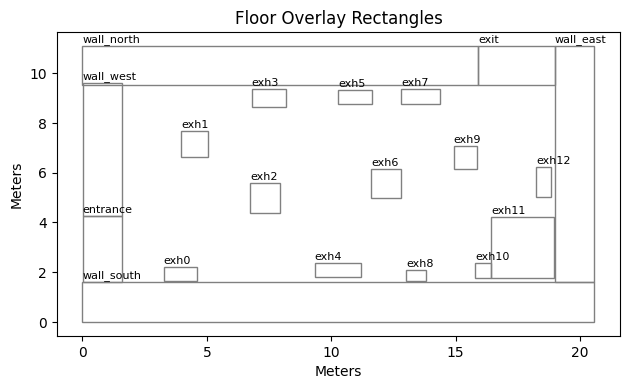

In [12]:
floor_rects_metric_inline_ir('/Users/iuliarusu/Documents/museum/drop_model_movement/floor_overlay_labels.csv')

In [13]:


def floorplan_trajectories_ir(
    rect_csv='floor_overlay_labels.csv',
    cluster_pattern='cluster_*.csv',
    cluster_dir='.',
    filter_files= None,
    plot_separate=True
):
    pix_to_m = 0.003175

    # ── Load rectangle overlay CSV ──
    rect_path = os.path.join(cluster_dir, rect_csv)
    T = pd.read_csv(rect_path)

    if filter_files:
        wanted = {os.path.basename(f) for f in filter_files}
        csv_files = [f for f in all_files if os.path.basename(f) in wanted]
    else:
        csv_files = all_files

    # ── Load all cluster CSVs ──
    csv_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))
    num_files = len(csv_files)
    colors = cm.get_cmap('tab20', num_files)  # A colormap with enough unique colors

    # ── Plot floorplan with overlaid trajectories ──
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    for _, row in T.iterrows():
        x = row['x'] * pix_to_m
        y = row['y'] * pix_to_m
        w = row['width'] * pix_to_m
        h = row['height'] * pix_to_m
        rect = plt.Rectangle((x, y), w, h, edgecolor='gray', facecolor='none', linewidth=1)
        ax1.add_patch(rect)
        ax1.text(x, y + h + 0.05, row['name'], fontsize=8, color='black', va='bottom', ha='left')

    for i, file in enumerate(csv_files):
        data = pd.read_csv(file)
        if data.shape[1] >= 3:
            x = data.iloc[:, 1] * pix_to_m  # Column 2 in MATLAB → index 1
            y = data.iloc[:, 2] * pix_to_m  # Column 3 in MATLAB → index 2
            ax1.plot(x, y, '.', color=colors(i), linewidth=0.5, markersize=1)

    ax1.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
    ax1.set_ylim(0, 3500 * pix_to_m)
    ax1.set_aspect('equal')
    ax1.set_title("Floor Plan and Trajectories in Meters")
    ax1.set_xlabel("X (m)")
    ax1.set_ylabel("Y (m)")
    plt.tight_layout()
    plt.show()

    # ── Plot each trajectory separately ──
    if plot_separate:
        cols = 4
        rows = int(np.ceil(num_files / cols))
        fig2, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()

        for i, file in enumerate(csv_files):
            ax = axes[i]
            data = pd.read_csv(file)
            if data.shape[1] >= 3:
                x = data.iloc[:, 1] * pix_to_m
                y = data.iloc[:, 2] * pix_to_m
                ax.plot(x, y, '.', color=colors(i), linewidth=0.5, markersize=1)
                ax.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
                ax.set_ylim(0, 3500 * pix_to_m)
                ax.set_title(f"cluster {os.path.basename(file)[8:11]}", fontsize=7)

        # Hide unused subplots
        for i in range(num_files, len(axes)):
            fig2.delaxes(axes[i])

        plt.tight_layout()
        plt.show()


In [60]:
def floorplan_trajectories_ir(
    rect_csv='floor_overlay_labels.csv',
    cluster_pattern='cluster_*.csv',
    cluster_dir='.',
    plot_separate=True,
    filter_files=None          # list of filenames (e.g. ['cluster_005.csv'])
):
    """
    Draw the floor plan and overlay selected trajectory CSVs.

    Parameters
    ----------
    rect_csv : str
        CSV containing rectangle definitions (x, y, width, height, name).
    cluster_pattern : str
        Glob pattern for trajectory CSVs (default 'cluster_*.csv').
    cluster_dir : str
        Directory where CSVs live.
    plot_separate : bool
        If True, make a subplot grid of individual traces.
    filter_files : list[str] | None
        If provided, only plot these filenames (basename match).
    """
    pix_to_m = 0.003175

    # ── read floor rectangles ────────────────────────────────────────────
    rect_path = os.path.join(cluster_dir, rect_csv)
    T = pd.read_csv(rect_path)

    # ── gather trajectory files ─────────────────────────────────────────-
    all_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))
    if filter_files:
        wanted = {os.path.basename(f) for f in filter_files}
        csv_files = [f for f in all_files if os.path.basename(f) in wanted]
    else:
        csv_files = all_files

    n_files = len(csv_files)
    colors = cm.get_cmap('tab20', n_files)

    # ── figure 1: floor plan + selected traces ───────────────────────────
    fig1, ax1 = plt.subplots(figsize=(8, 6))

    # draw rectangles
    for _, row in T.iterrows():
        x, y = row['x'] * pix_to_m, row['y'] * pix_to_m
        w, h = row['width'] * pix_to_m, row['height'] * pix_to_m
        ax1.add_patch(plt.Rectangle((x, y), w, h,
                                    edgecolor='gray', facecolor='none', lw=1))
        ax1.text(x, y + h + 0.05, row['name'],
                 fontsize=8, color='black', va='bottom', ha='left')

    # draw trajectories
    for i, f in enumerate(csv_files):
        data = pd.read_csv(f)
        x = data.iloc[:, 1] * pix_to_m
        y = data.iloc[:, 2] * pix_to_m
        ax1.plot(x, y, '.', color=colors(i), lw=0.5, ms=1,
                 label=os.path.basename(f))

    ax1.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
    ax1.set_ylim(0, 3500 * pix_to_m)
    ax1.set_aspect('equal')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Floor Plan and Selected Trajectories')
    # ax1.legend(fontsize=6, loc='upper right', bbox_to_anchor=(1.35, 1.0))
    plt.tight_layout()
    plt.show()

    if plot_separate and n_files:
            cols = 4
            rows = int(np.ceil(n_files / cols))
            fig2, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
            axes = axes.flatten()

            for i, f in enumerate(csv_files):
                data = pd.read_csv(f)
                x = data.iloc[:, 1] * pix_to_m
                y = data.iloc[:, 2] * pix_to_m
                ax = axes[i]

                # draw floor rectangles on each subplot
                for _, row in T.iterrows():
                    rect_x = row['x'] * pix_to_m
                    rect_y = row['y'] * pix_to_m
                    rect_w = row['width'] * pix_to_m
                    rect_h = row['height'] * pix_to_m
                    ax.add_patch(plt.Rectangle(
                        (rect_x, rect_y), rect_w, rect_h,
                        edgecolor='gray', facecolor='none', lw=0.5))
                    ax.text(rect_x, rect_y + rect_h + 0.02, row['name'],
                            fontsize=5, color='black', va='bottom', ha='left')

                ax.plot(x, y, '.', color=colors(i), lw=0.5, ms=1)
                ax.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
                ax.set_ylim(0, 3500 * pix_to_m)
                ax.set_aspect('equal')
                ax.set_title(f"cluster {os.path.basename(f)[8:11]}", fontsize=7)

            # remove empty panels
            for j in range(i + 1, len(axes)):
                fig2.delaxes(axes[j])

            plt.tight_layout()
            plt.show()

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_87228/3080272680.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_files)


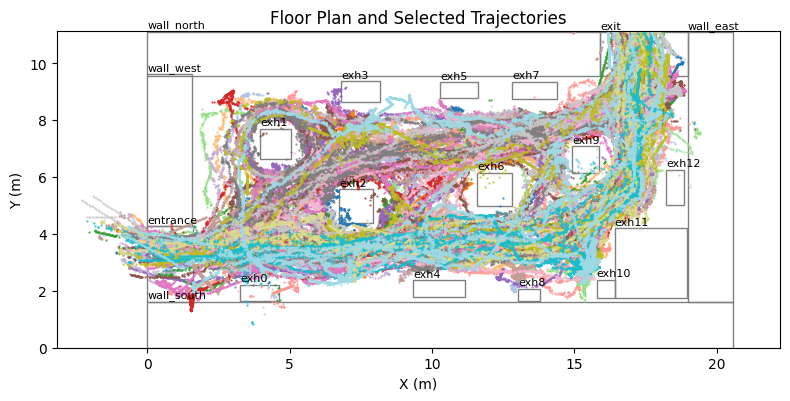

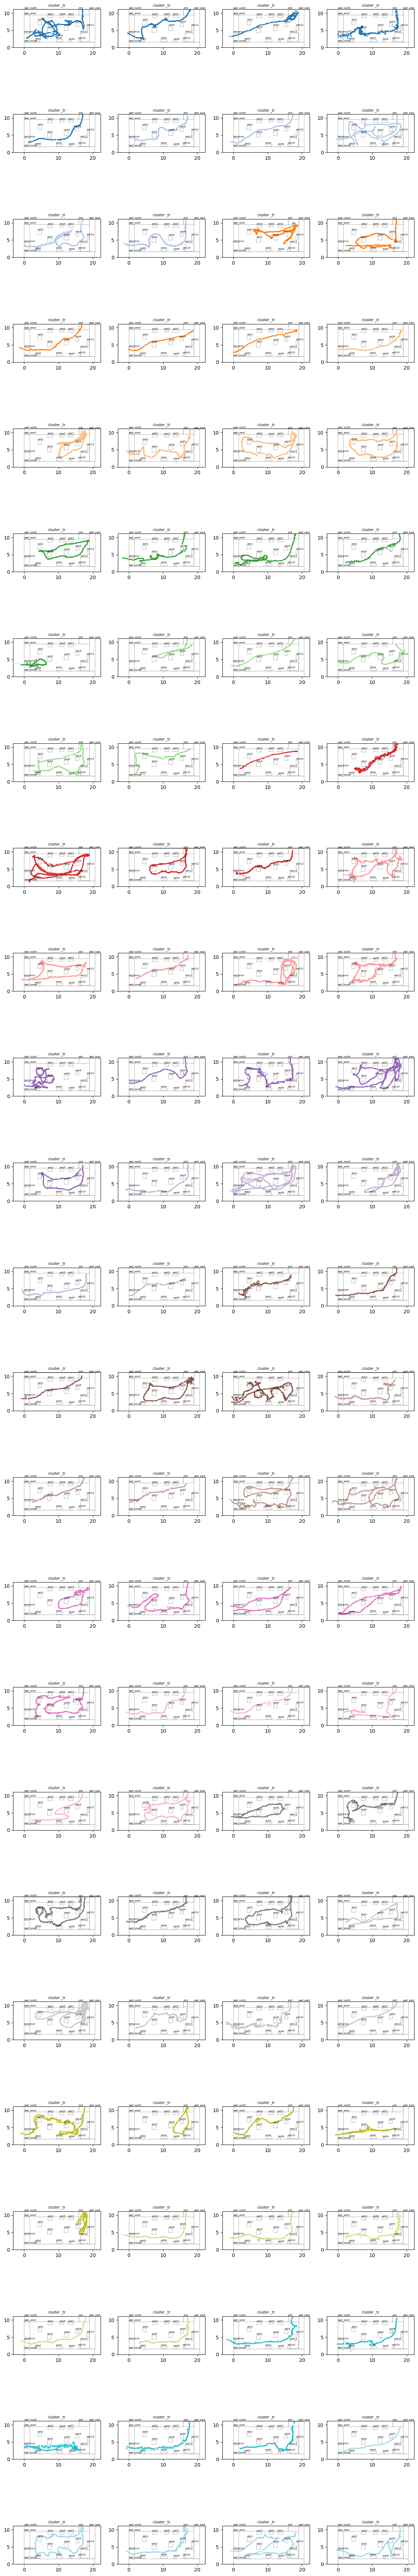

In [61]:
floorplan_trajectories_ir(cluster_pattern='*_track_*.csv', cluster_dir='more_data_2025')

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_62430/1352664879.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_files)


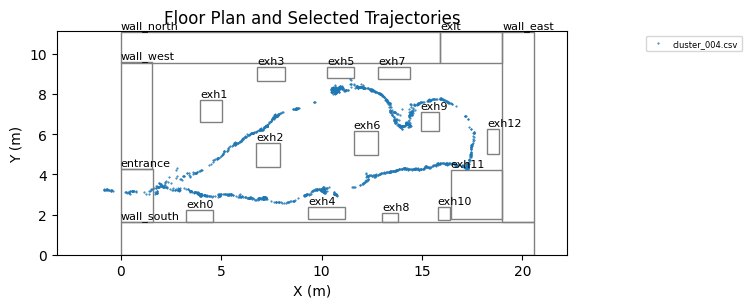

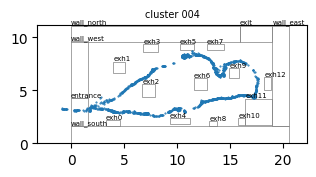

In [56]:
floorplan_trajectories_ir(
    cluster_dir='drop_model_movement',
    filter_files=['cluster_004.csv']
)

Divide the floor plan into state space


In [57]:
def floor_rects_metric_inline_ir_statespace(csvfile='floor_overlay_labels.csv', show_text=True):

    """Maps floorplan"""
    pix_to_m = 0.003175

    # Read CSV file
    T = pd.read_csv(csvfile)

    # Create plot
    fig, ax = plt.subplots()

    states = []
    for _, row in T.iterrows():
        x = row['x'] * pix_to_m
        y = row['y'] * pix_to_m
        w = row['width'] * pix_to_m
        h = row['height'] * pix_to_m

        rect = plt.Rectangle((x, y), w, h, edgecolor=[0.5, 0.5, 0.5], facecolor='none', linewidth=1)
        

        ax.add_patch(rect)



        if show_text:
            ax.text(x, y + h + 0.05, row['name'], color='black', fontsize=8,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_aspect('equal')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    plt.title('Floor Overlay Rectangles')
    ax.autoscale_view()
    plt.tight_layout()

    plt.show()

In [ ]:
#museum traces with meandering

short = [21, 23]
mid = [3, 4, 26, 17, 18, 7, 27]
long = [1, 2, 9]

# compute walkable area, and divide it into state space

In [17]:


def compute_walkable_mask_with_bounds(
    rect_csv,
    pix_to_m=0.003175,
    resolution=0.2,
    extra_exclude=None
):
    """
    Creates a binary walkable mask of the museum floor, excluding walls, exhibits,
    and any area outside the bounding box of interior features.

    Parameters
    ----------
    rect_csv : str
        Path to floorplan CSV file with rectangle definitions.
    pix_to_m : float
        Conversion factor from pixels to meters.
    resolution : float
        Size of grid cells (in meters).
    extra_exclude : list[str] | None
        Additional labels to exclude if needed.

    Returns
    -------
    mask : 2D bool array
        True where walkable, False where not.
    x_grid, y_grid : 2D float arrays
        Coordinate grid in meters.
    """
    T = pd.read_csv(rect_csv)

    # Step 1: Determine overall floorplan bounds
    x_max = ((T['x'] + T['width']) * pix_to_m).max()
    y_max = ((T['y'] + T['height']) * pix_to_m).max()

    x_coords = np.arange(0, x_max, resolution)
    y_coords = np.arange(0, y_max, resolution)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    mask = np.ones_like(x_grid, dtype=bool)

    # Step 2: Define things to exclude
    default_exclude = ['exit', 'wall_north', 'wall_south', 'wall_west', 'wall_east'] + \
                      [f"exh{i}" for i in range(20)]
    if extra_exclude:
        default_exclude.extend(extra_exclude)

    # Step 3: Exclude interior objects (walls, exhibits)
    for _, row in T.iterrows():
        name = str(row['name']).strip().lower()
        if any(ex in name for ex in default_exclude):
            rx = row['x'] * pix_to_m
            ry = row['y'] * pix_to_m
            rw = row['width'] * pix_to_m
            rh = row['height'] * pix_to_m
            inside_x = (x_grid >= rx) & (x_grid <= rx + rw)
            inside_y = (y_grid >= ry) & (y_grid <= ry + rh)
            mask &= ~(inside_x & inside_y)

    # Step 4: Enforce interior bounding box (exclude outer perimeter)
    interior = T[~T['name'].str.contains('wall', case=False)]
    x0 = (interior['x'] * pix_to_m).min()
    x1 = ((interior['x'] + interior['width']) * pix_to_m).max()
    y0 = (interior['y'] * pix_to_m).min()
    y1 = ((interior['y'] + interior['height']) * pix_to_m).max()

    inside_bounds = (x_grid >= x0) & (x_grid <= x1) & (y_grid >= y0) & (y_grid <= y1)
    mask &= inside_bounds

    return mask, x_grid, y_grid


In [18]:
mask, xg, yg = compute_walkable_mask_with_bounds(
    'drop_model_movement/floor_overlay_labels.csv',
    resolution=0.3
)

In [19]:
def discretize_walkable_area(mask, xg, yg):
    """
    Converts a walkable binary mask into discrete state grid.

    Parameters
    ----------
    mask : 2D np.array (bool)
        True where walkable.
    xg, yg : 2D np.array
        Meshgrid of X and Y coordinates (same shape as mask).

    Returns
    -------
    state_map : 2D np.array (int)
        Grid of same shape as mask: each walkable cell has a unique state ID,
        non-walkable cells are -1.
    state_lookup : dict[int, tuple[float, float]]
        Maps state ID to (x, y) coordinate center of that state.
    """
    state_map = -1 * np.ones_like(mask, dtype=int)  # default -1 = not walkable
    state_lookup = {}

    state_id = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                state_map[i, j] = state_id
                state_lookup[state_id] = (xg[i, j], yg[i, j])
                state_id += 1

    return state_map, state_lookup


In [20]:
state_map, state_lookup = discretize_walkable_area(mask, xg, yg)

In [21]:
np.where(state_map.T == 0)

(array([1]), array([6]))

In [22]:
np.where(np.flipud(state_map.T) == 0)

(array([67]), array([6]))

In [64]:
state_lookup

{0: (np.float64(0.3), np.float64(1.7999999999999998)),
 1: (np.float64(0.6), np.float64(1.7999999999999998)),
 2: (np.float64(0.8999999999999999), np.float64(1.7999999999999998)),
 3: (np.float64(1.2), np.float64(1.7999999999999998)),
 4: (np.float64(1.5), np.float64(1.7999999999999998)),
 5: (np.float64(1.7999999999999998), np.float64(1.7999999999999998)),
 6: (np.float64(2.1), np.float64(1.7999999999999998)),
 7: (np.float64(2.4), np.float64(1.7999999999999998)),
 8: (np.float64(2.6999999999999997), np.float64(1.7999999999999998)),
 9: (np.float64(3.0), np.float64(1.7999999999999998)),
 10: (np.float64(4.8), np.float64(1.7999999999999998)),
 11: (np.float64(5.1), np.float64(1.7999999999999998)),
 12: (np.float64(5.3999999999999995), np.float64(1.7999999999999998)),
 13: (np.float64(5.7), np.float64(1.7999999999999998)),
 14: (np.float64(6.0), np.float64(1.7999999999999998)),
 15: (np.float64(6.3), np.float64(1.7999999999999998)),
 16: (np.float64(6.6), np.float64(1.7999999999999998))

In [65]:
np.flipud(state_map).T[0][0]

np.int64(-1)

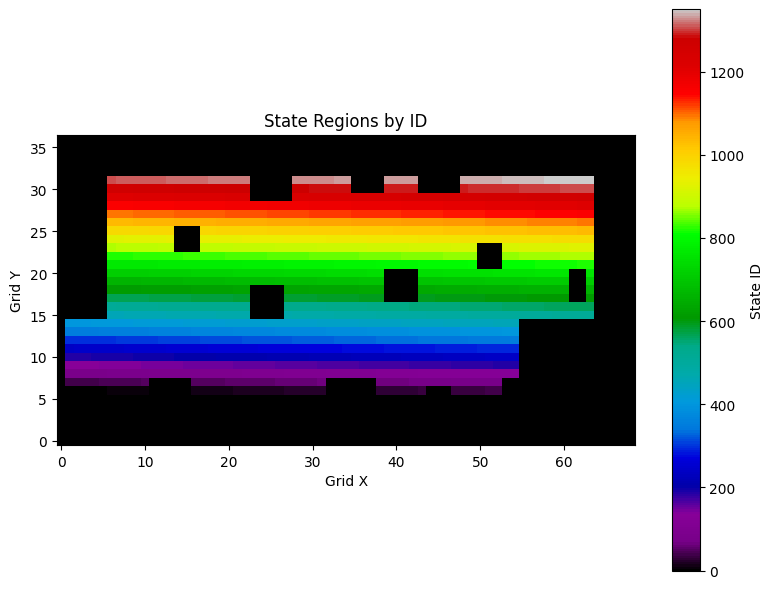

In [23]:
plt.figure(figsize=(8, 6))
plt.imshow(state_map, cmap='nipy_spectral', origin='lower', interpolation='none')
plt.colorbar(label='State ID')
plt.title("State Regions by ID")
plt.xlabel("Grid X")
plt.ylabel("Grid Y")
# plt.xlim(5, 10)  # meters
# plt.ylim(2, 10)   # meters
plt.tight_layout()
plt.show()

double check spaces above walls are not recognized as states

In [67]:
# T = pd.read_csv('drop_model_movement/floor_overlay_labels.csv')
# north_wall = T[T['name'] == 'wall_north'].iloc[0]

# x_north = north_wall['x'] * pix_to_m
# y_north = north_wall['y'] * pix_to_m
# w_north = north_wall['width'] * pix_to_m
# h_north = north_wall['height'] * pix_to_m

# print("North wall bounds:")
# print(f"x ∈ [{x_north:.2f}, {x_north + w_north:.2f}]")
# print(f"y ∈ [{y_north:.2f}, {y_north + h_north:.2f}]")

In [76]:
# for sid, (x, y) in state_lookup.items():
#     inside_x = (x >= x_north) and (x <= x_north + w_north)
#     inside_y = (y >= y_north) and (y <= y_north + h_north)
#     if inside_x and inside_y:
#         print(f"⚠️  State {sid} is inside the north wall at ({x:.2f}, {y:.2f})")

In [20]:
valid_state_ids = state_map[state_map >= 0]


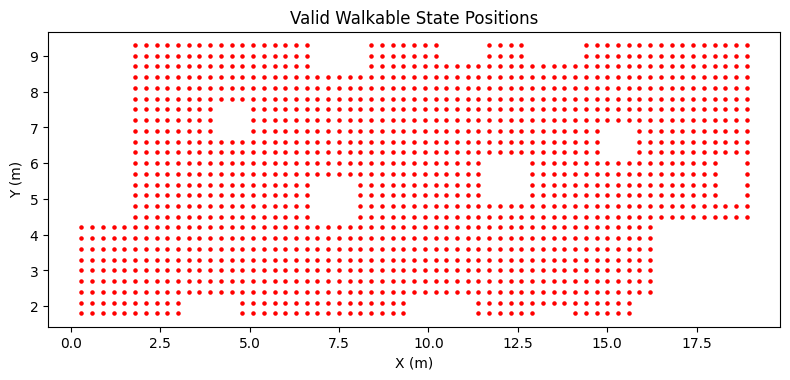

In [24]:
xs = [x for sid, (x, y) in state_lookup.items()]
ys = [y for sid, (x, y) in state_lookup.items()]

plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, c='red', s=5)
plt.gca().set_aspect('equal')
plt.title("Valid Walkable State Positions")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.tight_layout()
plt.show()

# view of traces in new discretized state space

In [47]:
def get_state_for_position(x, y, x_grid, y_grid, state_map):
    """
    Maps a continuous (x, y) position to its corresponding discrete state ID.
    Returns -1 if out of bounds or non-walkable.
    """
    dx = x_grid[0, 1] - x_grid[0, 0]
    dy = y_grid[1, 0] - y_grid[0, 0]

    col = int((x - x_grid[0, 0]) // dx)
    row = int((y - y_grid[0, 0]) // dy)

    if 0 <= row < state_map.shape[0] and 0 <= col < state_map.shape[1]:
        return state_map[row, col]
    return -1  # out of bounds or non-walkable


def map_trajectory_to_states(x_vals, y_vals, x_grid, y_grid, state_map):
    """
    Maps a full trajectory of (x_vals, y_vals) to a list of discrete state IDs.
    """
    return [get_state_for_position(x, y, x_grid, y_grid, state_map)
            for x, y in zip(x_vals, y_vals)]



In [83]:
# Load one cluster trace
data = pd.read_csv('drop_model_movement/cluster_007.csv', header=None)
x_traj = data.iloc[:, 1] * pix_to_m
y_traj = data.iloc[:, 2] * pix_to_m

# Map to states
state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)

In [25]:
visibility = pd.read_csv('/Users/iuliarusu/Documents/museum/drop_model_movement/walkable_positions_with_visibility.csv')
x = visibility.iloc[:, 1].values  
y = visibility.iloc[:, 2].values  
c = visibility.iloc[:, 3].values 

In [67]:
list(state_lookup.keys())[-1]

1351

In [56]:
# map load and map all clusters to states and make into a pd
def extract_states_traces(csv_file_list, pix_to_m, state_map, xg, yg):
    visibility_df = pd.read_csv('/Users/iuliarusu/Documents/museum/drop_model_movement/walkable_positions_with_visibility.csv')
    # x = visibility.iloc[:, 1].values  
    # y = visibility.iloc[:, 2].values  
    c = visibility_df.iloc[:, 3].values 
    traces = []
    width = max(xs) - min(xs)
    height = max(ys) - min(ys)

    W,H = state_map.T.shape
    nstates = state_map.max() + 1

    for file in csv_file_list:
        data = pd.read_csv(file)
        x_traj = data.iloc[:, 1] * pix_to_m
        y_traj = data.iloc[:, 2] * pix_to_m
        time = np.arange(0 , len(data.iloc[:, 0]))/ len(data.iloc[:, 0]) #normalized between 0 and 1
        
        state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)

       
        # # Step 1: Grab visited state IDs (filtering out -1s)
        # visited_state_ids = list(sid for sid in state_trace if sid >= 0)
        # visibilities = [c[sid] for sid in visited_state_ids]

        visited_state_ids = []
        normalized_state_ids = []
        visibilities = []
        visited_times = []
        for i, sid in enumerate(state_trace):
            if sid >= 0:
                normalized_state_ids.append(sid/nstates)  # normalize state ID
                visited_state_ids.append(sid)
                visibilities.append(c[sid])
                visited_times.append(time[i])





        # Step 2: Look up positions of these states
        visited_xs = [np.where(np.flipud(state_map).T == sid)[0][0] / W for sid in  visited_state_ids]
        visited_ys = [np.where(np.flipud(state_map).T == sid)[1][0] / H for sid in  visited_state_ids]
        assert(len(visited_times) == len(visited_xs) == len(visited_ys) == len(visited_state_ids) == len(visibilities))
        traces.append({
            'file': os.path.basename(file),
            'time': visited_times,
            'x': visited_xs,
            'y': visited_ys,
            'state': normalized_state_ids,
            'visibility': visibilities
        })
    return pd.DataFrame(traces)
        


In [28]:
time_traces = []
for file in csv_files:
    data = pd.read_csv(file, header=None)
    print(f"{os.path.basename(file)}: {len(data)} points")
    time = data.iloc[:, 0].values
    
    time_traces.append({
        'files': os.path.basename(file),
        'time': time
        
        })
time_traces_df = pd.DataFrame(time_traces)

20220825_track_00004_AB.csv: 4393 points
20220825_track_00006_BA.csv: 2655 points
20220825_track_00010_AB.csv: 3904 points
20220825_track_00017_BA.csv: 3392 points
20220825_track_00031_BA.csv: 920 points
20220825_track_00036_BA.csv: 2337 points
20220825_track_00050_AB.csv: 1042 points
20220825_track_00058_BA.csv: 3821 points
20220825_track_00123_BA.csv: 3143 points
20220825_track_00126_AB.csv: 1375 points
20220825_track_00131_BB.csv: 10103 points
20220825_track_00134_BA.csv: 2512 points
20220825_track_00167_BA.csv: 779 points
20220825_track_00187_BA.csv: 681 points
20220825_track_00205_AB.csv: 789 points
20220825_track_00206_AB.csv: 2865 points
20220825_track_00253_BB.csv: 4569 points
20220825_track_00255_BA.csv: 4021 points
20220825_track_00263_BB.csv: 2906 points
20220825_track_00296_BB.csv: 3277 points
20220825_track_00305_BB.csv: 5300 points
20220825_track_00308_AB.csv: 3759 points
20220825_track_00333_BA.csv: 1855 points
20220825_track_00360_BA.csv: 770 points
20220825_track_00371

In [76]:
time_traces_df['time'][0]
sample_time = time_traces_df['time'][0]




In [49]:
# extract states with meters and time with seconds
def extract_human_state_traces(csv_file_list, pix_to_m, state_map, xg, yg):
    """contained dataframe with x and y position in meters, and time in seconds of each valid visited state in any trajectory available. Add 0.033s to the time column.
   """
    visibility_df = pd.read_csv('/Users/iuliarusu/Documents/museum/drop_model_movement/walkable_positions_with_visibility.csv')
    # x = visibility.iloc[:, 1].values  
    # y = visibility.iloc[:, 2].values  
    c = visibility_df.iloc[:, 3].values 
    traces = []
    width = max(xs) - min(xs)
    height = max(ys) - min(ys)

    W,H = state_map.T.shape

    #change number of states to reflect augmented state
    nstates = state_map.max() + 1


    for file in csv_file_list:
        data = pd.read_csv(file)
        x_traj = data.iloc[:, 1] * pix_to_m
     
        y_traj = data.iloc[:, 2] * pix_to_m
        #for each file find min time and subtract min time from all other time points
        raw_time = data.iloc[:, 0]  #in seconds plus precision 
        #add 0.033s to each time point except the first one
        min_time_idx = np.argmin(raw_time)
        raw_min_time = raw_time[min_time_idx]
        time = (raw_time - raw_min_time)  # normalized time starting from 0
        
        #defined by x,y positions and state map, discretized 
        state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map) 

       
        # # Step 1: Grab visited state IDs (filtering out -1s)
        # visited_state_ids = list(sid for sid in state_trace if sid >= 0)
        # visibilities = [c[sid] for sid in visited_state_ids]

        visited_state_ids = []
        normalized_state_ids = []
        visibilities = []
        visited_times = []
        visited_xs = []
        visited_ys = []
        for i, sid in enumerate(state_trace):
            if sid >= 0:
                normalized_state_ids.append(sid/nstates)  # normalize state ID
                visited_state_ids.append(sid)
                visibilities.append(c[sid])
                visited_times.append(time[i])
                # graab the x_traj and y_traj positions
                visited_xs.append(x_traj[i])
                visited_ys.append(y_traj[i])





       
        assert(len(visited_times) == len(visited_xs) == len(visited_ys) == len(visited_state_ids) == len(visibilities))
        traces.append({
            'file': os.path.basename(file),
            'time': visited_times,
            'x': visited_xs,
            'y': visited_ys,
            'state': normalized_state_ids,
            'visibility': visibilities
        })
    return pd.DataFrame(traces)

In [57]:
museum_df2 = extract_states_traces(csv_files, pix_to_m, state_map, xg, yg)

In [58]:
museum_df2

,file,time,x,y,state,visibility
0,20220825_track_00004_AB.csv,"[0.0, 0.00022768670309653916, 0.00045537340619...","[0.028985507246376812, 0.028985507246376812, 0...","[0.7297297297297297, 0.7297297297297297, 0.729...","[0.09911242603550297, 0.09911242603550297, 0.0...","[8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
1,20220825_track_00006_BA.csv,"[0.06593820648078372, 0.06631499623210249, 0.0...","[0.8115942028985508, 0.8115942028985508, 0.811...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,20220825_track_00010_AB.csv,"[0.005380476556495004, 0.005636689725851908, 0...","[0.014492753623188406, 0.028985507246376812, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17899408284023668, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 8, ..."
3,20220825_track_00017_BA.csv,"[0.04217045119433795, 0.042465349454438216, 0....","[0.7971014492753623, 0.8115942028985508, 0.797...","[0.16216216216216217, 0.16216216216216217, 0.1...","[0.9607988165680473, 0.9615384615384616, 0.993...","[10, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9,..."
4,20220825_track_00031_BA.csv,"[0.08922742110990206, 0.09031556039173014, 0.0...","[0.7971014492753623, 0.7971014492753623, 0.797...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9933431952662722, 0.9933431952662722, 0.993...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
...,...,...,...,...,...,...
95,20220825_track_02117_AB.csv,"[0.0, 0.00044742729306487697, 0.00089485458612...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7837837837837838, 0.7837837837837838, 0.783...","[0.03106508875739645, 0.03106508875739645, 0.0...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
96,20220826_track_00008_BB.csv,"[0.04019779869197639, 0.04275003987876854, 0.0...","[0.8115942028985508, 0.8115942028985508, 0.811...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, ..."
97,20220826_track_00013_BA.csv,"[0.29768941429339063, 0.2982267598065556, 0.29...","[0.782608695652174, 0.782608695652174, 0.78260...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.992603550295858, 0.992603550295858, 0.99260...","[8, 8, 8, 8, 9, 8, 10, 10, 9, 10, 8, 9, 9, 9, ..."
98,20220826_track_00030_AB.csv,"[0.0024760647078243643, 0.0025586001980851766,...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6486486486486487, 0.648...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."


In [59]:
%store museum_df2

Stored 'museum_df2' (DataFrame)


In [59]:
%store -r state_map

In [52]:
human_df2 = extract_human_state_traces(csv_files, pix_to_m, state_map, xg, yg)

In [54]:
%store human_df2

Stored 'human_df2' (DataFrame)


In [53]:
human_df2

,file,time,x,y,state,visibility
0,20220825_track_00004_AB.csv,"[0.0, 0.03299999999944703, 0.06699999999909778...","[0.6274752499999999, 0.65439925, 0.55768875, 0...","[2.7235467499999997, 2.71897475, 2.711831, 2.7...","[0.09911242603550297, 0.09911242603550297, 0.0...","[8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
1,20220825_track_00006_BA.csv,"[5.833000000002357, 5.866000000001804, 5.90000...","[16.8767125, 16.96234225, 16.97618525, 16.9695...","[9.51938025, 9.5390335, 9.52687325, 9.54909825...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,20220825_track_00010_AB.csv,"[0.7000000000007276, 0.7330000000001746, 0.765...","[0.408686, 0.6739255, 0.6202362499999999, 0.38...","[3.4189352499999996, 3.35353025, 3.4455735, 3....","[0.17825443786982248, 0.17899408284023668, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 8, ..."
3,20220825_track_00017_BA.csv,"[4.766999999999825, 4.799999999999272, 4.83300...","[16.78905075, 16.96856525, 16.725265, 16.93475...","[9.2076905, 9.27592125, 9.32195875, 9.547352, ...","[0.9607988165680473, 0.9615384615384616, 0.993...","[10, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9,..."
4,20220825_track_00031_BA.csv,"[2.7339999999967404, 2.7669999999998254, 2.799...","[16.78530425, 16.780129, 16.7749855, 16.769810...","[9.5833565, 9.56497325, 9.5465265, 9.52807975,...","[0.9933431952662722, 0.9933431952662722, 0.993...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
...,...,...,...,...,...,...
95,20220825_track_02117_AB.csv,"[0.0, 0.033000000003085006, 0.0670000000027357...","[1.601978, 1.608582, 1.61483675, 1.6280765, 1....","[2.300732, 2.3040975, 2.30724075, 2.29269925, ...","[0.03106508875739645, 0.03106508875739645, 0.0...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
96,20220826_track_00008_BB.csv,"[8.399999999999636, 8.932999999999993, 8.96699...","[16.91522525, 16.82842075, 16.8265475, 16.8188...","[9.59983475, 9.59450075, 9.54935225, 9.5478917...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, ..."
97,20220826_track_00013_BA.csv,"[18.46600000000035, 18.5, 18.533000000000357, ...","[16.38023775, 16.37928525, 16.37833275, 16.560...","[9.596405749999999, 9.58618225, 9.575927, 9.40...","[0.992603550295858, 0.992603550295858, 0.99260...","[8, 8, 8, 8, 9, 8, 10, 10, 9, 10, 8, 9, 9, 9, ..."
98,20220826_track_00030_AB.csv,"[1.0, 1.032999999999447, 1.065999999998894, 1....","[0.30210125, 0.43345100000000003, 0.5087302499...","[3.7237987499999994, 3.6714747499999993, 3.675...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."


In [ ]:
#augmented states, currently used for museum_df #########
def extract_states_traces(csv_file_list, pix_to_m, state_map, xg, yg):
    visibility_df = pd.read_csv('/Users/iuliarusu/Documents/museum/drop_model_movement/walkable_positions_with_visibility.csv')
    # x = visibility.iloc[:, 1].values  
    # y = visibility.iloc[:, 2].values  
    c = visibility_df.iloc[:, 3].values 
    traces = []
    width = max(xs) - min(xs)
    height = max(ys) - min(ys)

    W,H = state_map.T.shape

    #change number of states to reflect augmented state
    nstates = state_map.max() + 1

    for file in csv_file_list:
        data = pd.read_csv(file, header=None)
        x_traj = data.iloc[:, 1] * pix_to_m
        y_traj = data.iloc[:, 2] * pix_to_m
        time = np.arange(0 , len(data.iloc[:, 0]))/ len(data.iloc[:, 0]) #normalized between 0 and 1
        
        state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)

       
        # # Step 1: Grab visited state IDs (filtering out -1s)
        # visited_state_ids = list(sid for sid in state_trace if sid >= 0)
        # visibilities = [c[sid] for sid in visited_state_ids]

        visited_state_ids = []
        normalized_state_ids = []
        visibilities = []
        visited_times = []
        for i, sid in enumerate(state_trace):
            if sid >= 0:
                normalized_state_ids.append(sid/nstates)  # normalize state ID
                visited_state_ids.append(sid)
                visibilities.append(c[sid])
                visited_times.append(time[i])





        # Step 2: Look up positions of these states
        visited_xs = [np.where(np.flipud(state_map).T == sid)[0][0] / W for sid in  visited_state_ids]
        visited_ys = [np.where(np.flipud(state_map).T == sid)[1][0] / H for sid in  visited_state_ids]
        assert(len(visited_times) == len(visited_xs) == len(visited_ys) == len(visited_state_ids) == len(visibilities))
        traces.append({
            'file': os.path.basename(file),
            'time': visited_times,
            'x': visited_xs,
            'y': visited_ys,
            'state': normalized_state_ids,
            'visibility': visibilities
        })
    return pd.DataFrame(traces)
        


In [69]:

def extract_states_traces_w_action(csv_file_list, pix_to_m, state_map, xg, yg):
    visibility_df = pd.read_csv('/Users/iuliarusu/Documents/museum/drop_model_movement/walkable_positions_with_visibility.csv')
    # x = visibility.iloc[:, 1].values  
    # y = visibility.iloc[:, 2].values  
    c = visibility_df.iloc[:, 3].values 
    traces = []


    W,H = state_map.T.shape

    #change number of states to reflect augmented state
    nstates = state_map.max() + 1

    for file in csv_file_list:
        data = pd.read_csv(file)
        x_traj = data.iloc[:, 1] * pix_to_m
        y_traj = data.iloc[:, 2] * pix_to_m
        state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)
        time = np.arange(0 , len(data.iloc[:, 0]))/ len(data.iloc[:, 0]) #normalized between 0 and 1        

        visited_state_ids = []
        normalized_state_ids = []
        visibilities = []
        visited_times = []
        past_actions = []
        
        for i, sid in enumerate(state_trace):
            if sid >= 0:
                normalized_state_ids.append(sid/nstates)  # normalize state ID
                visited_state_ids.append(sid)
                visibilities.append(c[sid])
                visited_times.append(time[i])


        #unnormalized positions
        xs = [np.where(np.flipud(state_map).T == sid)[0][0]  for sid in  visited_state_ids]
        ys = [np.where(np.flipud(state_map).T == sid)[1][0]  for sid in  visited_state_ids]

        visited_xs = [x/ W for x in xs]
        visited_ys = [y/ H for y in ys]
       


        # next positions via i+1 (shifted lists)
        xs_curr, xs_next = xs[:-1], xs[1:]
        ys_curr, ys_next = ys[:-1], ys[1:]

        # integer step deltas
        dxs = [xn - xc for xc, xn in zip(xs_curr, xs_next)]
        dys = [yn - yc for yc, yn in zip(ys_curr, ys_next)]


        action_deltas = {
            (0, 0): 0,    # stay
            (0, -1): 1,   # up
            (0, 1): 2,    # down
            (-1, 0): 3,   # left
            (1, 0): 4,    # right
        }
        
        for dx, dy in zip(dxs, dys):
            #for every dx, dy pair in the trajectory, compute its dot product with each action delta
            dots = [np.dot((dx, dy), (kx, ky)) for (kx, ky), value in action_deltas.items()] 
            #get the action corresponding to the max dot product
            max_dot_index = np.argmax(dots) #index corresponding to the max dot product, which is the action 
            past_actions.append(max_dot_index)
        
        
     

        
        # [action_deltas.get((dx, dy), -1) for dx, dy in zip(dxs, dys)]
      
        past_actions = [0] + past_actions # first action is 'stay' by default

        assert(len(visited_times) == len(visited_xs) == len(visited_ys) == len(visited_state_ids) == len(visibilities) == len(past_actions))
       
        traces.append({
            'file': os.path.basename(file),
            'time': visited_times,
            'x': visited_xs,
            'y': visited_ys,
            'state': normalized_state_ids,
            'visibility': visibilities, 
            'memory': past_actions
        })
    return pd.DataFrame(traces)

In [71]:
museum_df_w_actions = extract_states_traces_w_action(csv_files, pix_to_m, state_map, xg, yg)

In [72]:
museum_df_w_actions

,file,time,x,y,state,visibility,memory
0,20220825_track_00004_AB.csv,"[0.0, 0.00022768670309653916, 0.00045537340619...","[0.028985507246376812, 0.028985507246376812, 0...","[0.7297297297297297, 0.7297297297297297, 0.729...","[0.09911242603550297, 0.09911242603550297, 0.0...","[8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 3, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,20220825_track_00006_BA.csv,"[0.06593820648078372, 0.06631499623210249, 0.0...","[0.8115942028985508, 0.8115942028985508, 0.811...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,20220825_track_00010_AB.csv,"[0.005380476556495004, 0.005636689725851908, 0...","[0.014492753623188406, 0.028985507246376812, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17899408284023668, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 8, ...","[0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, ..."
3,20220825_track_00017_BA.csv,"[0.04217045119433795, 0.042465349454438216, 0....","[0.7971014492753623, 0.8115942028985508, 0.797...","[0.16216216216216217, 0.16216216216216217, 0.1...","[0.9607988165680473, 0.9615384615384616, 0.993...","[10, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9,...","[0, 4, 1, 4, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, ..."
4,20220825_track_00031_BA.csv,"[0.08922742110990206, 0.09031556039173014, 0.0...","[0.7971014492753623, 0.7971014492753623, 0.797...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9933431952662722, 0.9933431952662722, 0.993...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
95,20220825_track_02117_AB.csv,"[0.0, 0.00044742729306487697, 0.00089485458612...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7837837837837838, 0.7837837837837838, 0.783...","[0.03106508875739645, 0.03106508875739645, 0.0...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
96,20220826_track_00008_BB.csv,"[0.04019779869197639, 0.04275003987876854, 0.0...","[0.8115942028985508, 0.8115942028985508, 0.811...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ..."
97,20220826_track_00013_BA.csv,"[0.29768941429339063, 0.2982267598065556, 0.29...","[0.782608695652174, 0.782608695652174, 0.78260...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.992603550295858, 0.992603550295858, 0.99260...","[8, 8, 8, 8, 9, 8, 10, 10, 9, 10, 8, 9, 9, 9, ...","[0, 0, 0, 4, 2, 1, 2, 0, 3, 4, 1, 4, 0, 0, 0, ..."
98,20220826_track_00030_AB.csv,"[0.0024760647078243643, 0.0025586001980851766,...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6486486486486487, 0.648...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, ..."


In [73]:
museum_df2_w_actions = museum_df_w_actions

In [74]:
%store museum_df2_w_actions

Stored 'museum_df2_w_actions' (DataFrame)


In [38]:
for i in range(len(museum_df_w_actions['state'])):
    print(len(museum_df_w_actions['state'][i]))

10289
32172
2265
1990
3893
7021
32182
5487
5349
2691
2454
2797
3969


In [ ]:
####editing######
def extract_states_traces_w_action_dwelltimes(csv_file_list, pix_to_m, state_map, xg, yg):
    visibility_df = pd.read_csv('/Users/iuliarusu/Documents/museum/drop_model_movement/walkable_positions_with_visibility.csv')
    # x = visibility.iloc[:, 1].values  
    # y = visibility.iloc[:, 2].values  
    c = visibility_df.iloc[:, 3].values 
    traces = []


    W,H = state_map.T.shape

    #change number of states to reflect augmented state
    nstates = state_map.max() + 1

    for file in csv_file_list:
        data = pd.read_csv(file, header=None)
        x_traj = data.iloc[:, 1] * pix_to_m
        y_traj = data.iloc[:, 2] * pix_to_m
        state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)
        time = np.arange(0 , len(data.iloc[:, 0]))/ len(data.iloc[:, 0]) #normalized between 0 and 1        

        visited_state_ids = []
        normalized_state_ids = []
        visibilities = []
        visited_times = []
        past_actions = []

        
        
        for i, sid in enumerate(state_trace):
            if sid >= 0:
                normalized_state_ids.append(sid/nstates)  # normalize state ID

                visited_state_ids.append(sid)

                visibilities.append(c[sid])
                visited_times.append(time[i])
        
        dwell_times = []
        for i in range(len(visited_state_ids)):
            


        ### look through normalized state trace, and see if it is next to a dwell region, create a new column for dwell times
        ###assert dwell times has the same length as 

        #unnormalized positions
        xs = [np.where(np.flipud(state_map).T == sid)[0][0]  for sid in  visited_state_ids]
        ys = [np.where(np.flipud(state_map).T == sid)[1][0]  for sid in  visited_state_ids]

        visited_xs = [x/ W for x in xs]
        visited_ys = [y/ H for y in ys]
       


        # next positions via i+1 (shifted lists)
        xs_curr, xs_next = xs[:-1], xs[1:]
        ys_curr, ys_next = ys[:-1], ys[1:]

        # integer step deltas
        dxs = [xn - xc for xc, xn in zip(xs_curr, xs_next)]
        dys = [yn - yc for yc, yn in zip(ys_curr, ys_next)]


        action_deltas = {
            (0, 0): 0,    # stay
            (0, -1): 1,   # up
            (0, 1): 2,    # down
            (-1, 0): 3,   # left
            (1, 0): 4,    # right
        }
        
        for dx, dy in zip(dxs, dys):
            #for every dx, dy pair in the trajectory, compute its dot product with each action delta
            dots = [np.dot((dx, dy), (kx, ky)) for (kx, ky), value in action_deltas.items()] 
            #get the action corresponding to the max dot product
            max_dot_index = np.argmax(dots) #index corresponding to the max dot product, which is the action 
            past_actions.append(max_dot_index)
        
        
     

        
        # [action_deltas.get((dx, dy), -1) for dx, dy in zip(dxs, dys)]
      
        past_actions = [0] + past_actions # first action is 'stay' by default

        assert(len(visited_times) == len(visited_xs) == len(visited_ys) == len(visited_state_ids) == len(visibilities) == len(past_actions))
       
        traces.append({
            'file': os.path.basename(file),
            'time': visited_times,
            'x': visited_xs,
            'y': visited_ys,
            'state': normalized_state_ids,
            'visibility': visibilities, 
            'memory': past_actions
        })
    return pd.DataFrame(traces)

In [33]:
np.isnan(museum_df_w_actions['memory'][3]).sum()

np.int64(0)

In [62]:
%store museum_df_w_actions

Stored 'museum_df_w_actions' (DataFrame)


In [112]:
%store state_map

Stored 'state_map' (ndarray)


In [132]:
df = extract_states_traces(csv_files, pix_to_m, state_map, xg, yg)

In [134]:
museum_df = df

In [3]:
%store -r museum_df

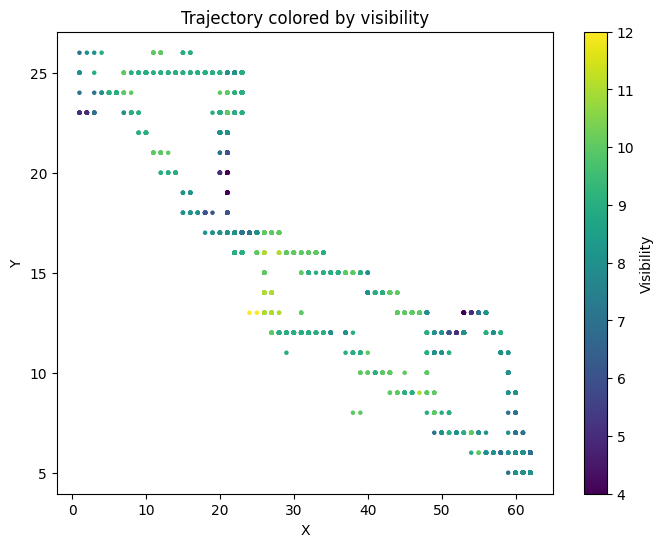

In [100]:
plt.figure(figsize=(8, 6))
plt.scatter(
    x=df.iloc[6, 2],        # x coordinates
    y=df.iloc[6, 3],        # y coordinates
    c=df.iloc[6]["visibility"],  # colors
    cmap="viridis",
    s=5
)
plt.colorbar(label="Visibility")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Trajectory colored by visibility")
plt.show()

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_83901/3997091187.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = df.iloc[6, 2], y= df.iloc[6, 3], s=5, cmap='viridis')


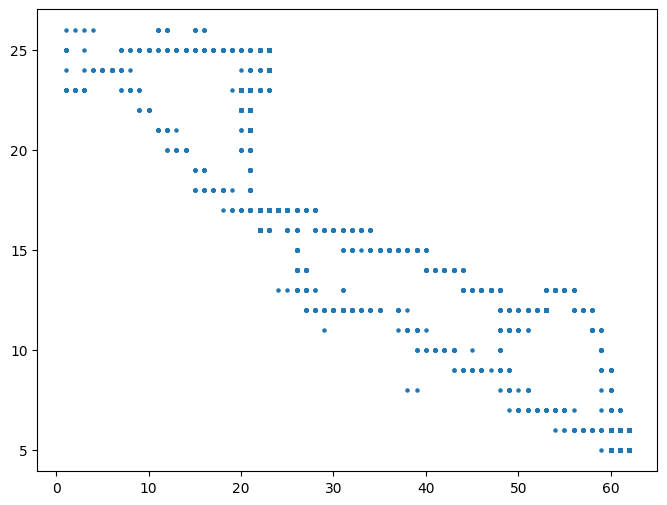

In [99]:
plt.figure(figsize=(8, 6))
plt.scatter(x = df.iloc[6, 2], y= df.iloc[6, 3], s=5, cmap='viridis')

In [ ]:

# Step 1: Unique visited state IDs (filtering out -1s)
visited_state_ids = set(sid for sid in state_trace if sid >= 0)

# Step 2: Look up positions of these states
visited_xs = [state_lookup[sid][0] for sid in visited_state_ids]
visited_ys = [state_lookup[sid][1] for sid in visited_state_ids]

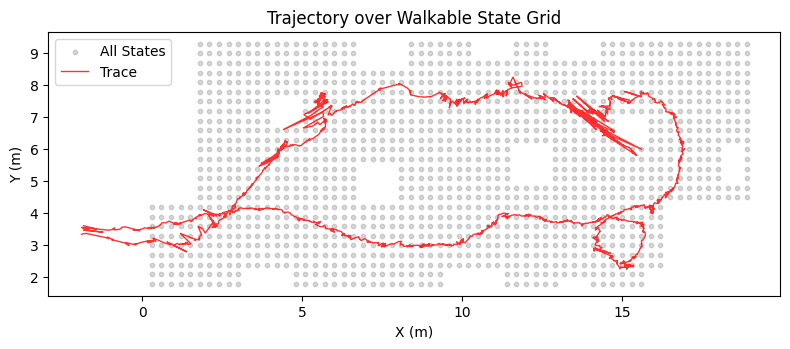

In [39]:
xs = [x for sid, (x, y) in state_lookup.items()]
ys = [y for sid, (x, y) in state_lookup.items()]

plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, s=10, alpha=0.3, color='gray', label='All States')
plt.plot(x_traj, y_traj, '-', color='red', linewidth=1.0, alpha=0.8, label='Trace')
plt.gca().set_aspect('equal')
plt.legend()
plt.title("Trajectory over Walkable State Grid")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.tight_layout()
plt.show()

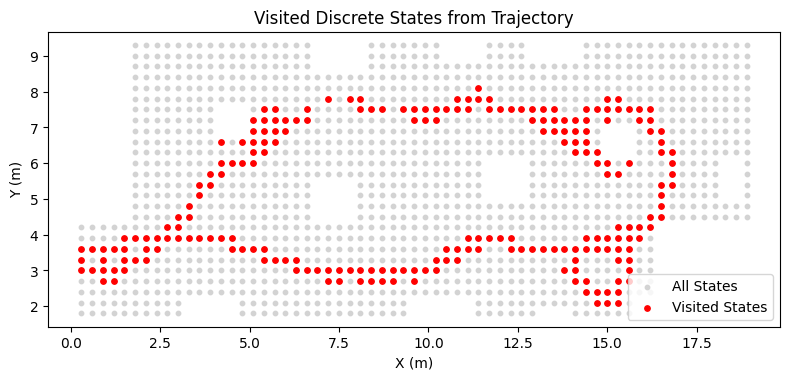

In [40]:
# Step 1: Unique visited state IDs (filtering out -1s)
visited_state_ids = set(sid for sid in state_trace if sid >= 0)

# Step 2: Look up positions of these states
visited_xs = [state_lookup[sid][0] for sid in visited_state_ids]
visited_ys = [state_lookup[sid][1] for sid in visited_state_ids]

# Step 3: Plot
plt.figure(figsize=(8, 6))

# Background: all states (gray)
all_xs = [x for sid, (x, y) in state_lookup.items()]
all_ys = [y for sid, (x, y) in state_lookup.items()]
plt.scatter(all_xs, all_ys, c='lightgray', s=10, label='All States')

# Highlight: visited states (red)
plt.scatter(visited_xs, visited_ys, c='red', s=15, label='Visited States')

plt.gca().set_aspect('equal')
plt.title("Visited Discrete States from Trajectory")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
########## creates a radius around each exhibit and finds which state ids from state_map are within that radius ##########

from scipy.ndimage import binary_dilation


# Parameters
resolution = 0.3
csv_path = 'drop_model_movement/floor_overlay_labels.csv'

# Step 1: Load and identify exhibit locations
T = pd.read_csv(csv_path)
exhibit_mask = np.zeros_like(mask, dtype=bool)

for _, row in T.iterrows():
    if 'exh' in str(row['name']).lower():  # Adjust to your column name
        x_start = int(row['x'] * 0.003175 // resolution)
        x_end = int((row['x'] + row['width']) * 0.003175 // resolution)
        y_start = int(row['y'] * 0.003175 // resolution)
        y_end = int((row['y'] + row['height']) * 0.003175 // resolution)
        exhibit_mask[y_start:y_end+1, x_start:x_end+1] = True

# Step 2: Dilate to define "nearby" region (e.g., within 2 cells)
near_exhibit_mask = binary_dilation(exhibit_mask, iterations=4)

##grab near states
walkable_states = state_map >= 0

# Get unique state IDs that are both near exhibits *and* valid states
near_exhibit_state_ids = np.unique(state_map[near_exhibit_mask & walkable_states])

# print("Number of states near exhibits:", len(near_exhibit_state_ids))
# print("Example state IDs:", near_exhibit_state_ids[:20])

near_states_per_exhibit = {}  # {exhibit_name: np.array of state_ids}

for _, row in T.iterrows():
    if 'exh' not in str(row['name']).lower():
        continue

    # 1. Build a mask for THIS exhibit only
    single_exhibit_mask = np.zeros_like(mask, dtype=bool)

    x_start = int(row['x'] * 0.003175 // resolution)
    x_end   = int((row['x'] + row['width'])  * 0.003175 // resolution)
    y_start = int(row['y'] * 0.003175 // resolution)
    y_end   = int((row['y'] + row['height']) * 0.003175 // resolution)

    single_exhibit_mask[y_start:y_end+1, x_start:x_end+1] = True

    # 2. Dilate to get the "near this exhibit" region
    near_single_exhibit_mask = binary_dilation(single_exhibit_mask, iterations=4)

    # 3. Grab unique state IDs that are:
    #    - near this exhibit
    #    - valid walkable states
    state_ids = np.unique(state_map[near_single_exhibit_mask & walkable_states])

    # 4. Store them keyed by exhibit name (or use an ID/index if you prefer)
    exhibit_name = str(row['name'])
    near_states_per_exhibit[exhibit_name] = state_ids

# Example: inspect results
for name, sids in list(near_states_per_exhibit.items())[:5]:
    print(f"Exhibit: {name}")
    print(f"  #nearby states: {len(sids)}")
    print(f"  example state_ids: {sids[:10]}")

Exhibit: exh7
  #nearby states: 66
  example state_ids: [1015 1016 1017 1018 1019 1020 1072 1073 1074 1075]
Exhibit: exh9
  #nearby states: 95
  example state_ids: [550 551 552 553 599 600 601 602 603 604]
Exhibit: exh6
  #nearby states: 113
  example state_ids: [332 333 334 335 336 385 386 387 388 389]
Exhibit: exh4
  #nearby states: 58
  example state_ids: [21 22 23 24 25 26 27 28 29 59]
Exhibit: exh0
  #nearby states: 54
  example state_ids: [ 5  6  7  8  9 10 11 12 13 43]
